## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems (Fall 2020)

#### Dr. Haiquan Chen, California State University, Sacramento

In [ ]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
#Perry Gill, 219965110, CSC180, Project 3, 10/30/2020
#Mary Ballesteros 219965110, CSC180, Project 3, 10/30/2020
#Rajvee Modi 219712052, CSC180, Project 3, 10/30/2020


















## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
#  Load cifar-10 data and split it to training and test


from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

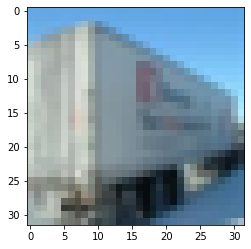

In [ ]:
# print it out as image

import matplotlib.pyplot as plt


plt.imshow(x_train[15])

In [ ]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [ ]:
y_train.shape

# expected output: (50000,)

(50000,)

In [ ]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [ ]:
y_test.shape

# expected output: (10000,)

(10000,)

In [ ]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Convert data from int to float and normalize it


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))


model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))




















In [ ]:

# Print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          3

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train, y_train, callbacks=[monitor], epochs=50, batch_size=64, verbose=2, validation_data=(x_test, y_test))





















Epoch 1/50
782/782 - 6s - loss: 1.8605 - accuracy: 0.3004 - val_loss: 1.4990 - val_accuracy: 0.4403
Epoch 2/50
782/782 - 6s - loss: 1.4369 - accuracy: 0.4781 - val_loss: 1.2622 - val_accuracy: 0.5540
Epoch 3/50
782/782 - 6s - loss: 1.2672 - accuracy: 0.5458 - val_loss: 1.1870 - val_accuracy: 0.5762
Epoch 4/50
782/782 - 5s - loss: 1.1572 - accuracy: 0.5927 - val_loss: 1.0990 - val_accuracy: 0.6162
Epoch 5/50
782/782 - 5s - loss: 1.0796 - accuracy: 0.6236 - val_loss: 0.9598 - val_accuracy: 0.6586
Epoch 6/50
782/782 - 5s - loss: 1.0060 - accuracy: 0.6502 - val_loss: 1.0182 - val_accuracy: 0.6494
Epoch 7/50
782/782 - 5s - loss: 0.9607 - accuracy: 0.6680 - val_loss: 0.8985 - val_accuracy: 0.6892
Epoch 8/50
782/782 - 5s - loss: 0.9126 - accuracy: 0.6856 - val_loss: 0.8659 - val_accuracy: 0.6942
Epoch 9/50
782/782 - 5s - loss: 0.8806 - accuracy: 0.6964 - val_loss: 0.8833 - val_accuracy: 0.6904
Epoch 10/50
782/782 - 5s - loss: 0.8555 - accuracy: 0.7082 - val_loss: 0.8552 - val_accuracy: 0.7052

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [ ]:
from sklearn import metrics


pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
y_true= np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


Accuracy score: 0.7566
Precision score: 0.7544874565575448
Recall score: 0.7566
F1 score: 0.750658291061047


### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

Image 1 is a dog our model predicted a dog
Image 2 is a cat our model predicted a frog
Image 3 is a frog our model predicted a frog
Image 4 is a truck our model predicted a truck
Image 5 is a horse our model predicted a horse


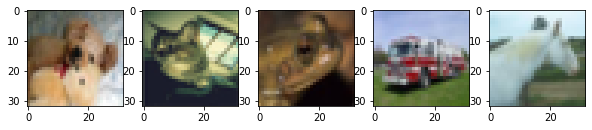

In [ ]:
import random

def displayImage(x_test, index):

  return 


stop = len(x_test)
label = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

figure = plt.figure(figsize=(10,10))

for i in range(1,6):
    index = random.randrange(stop)
    figure.add_subplot(4, 5, i)
    plt.imshow(x_test[index])

    print('Image ' + str(i) + ' is a ' + label[y_true[index]] + ' our model predicted a '+ label[pred[index]])










## Part II:   CNN model with Transfer Learning

In [ ]:
# We load data again.   The data split between train and test sets:
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

num_classes = 10


170500096/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Things to note: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### (2) Apply upsampling to x_train and x_test seperately. 

In [ ]:
import skimage.transform
import numpy as np

new_x_train = []


for image in x_train:
  upsampledImage = skimage.transform.resize(image, (64,64))
  new_x_train.append(upsampledImage)
                         
    
    

# this process may take about a few minutes ....

In [ ]:
new_x_train = np.asarray(new_x_train);


In [ ]:
new_x_train.shape

(50000, 64, 64, 3)

In [ ]:
new_x_test = []


for image in x_test:
  upsampledImage = skimage.transform.resize(image, (64,64))
  new_x_test.append(upsampledImage)
    


# this process may take about a few minutes ....

In [ ]:
new_x_test = np.asarray(new_x_test);


In [ ]:
new_x_test.shape

(10000, 64, 64, 3)


### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [ ]:
#convert 2D to 1D by using reshape() function
import tensorflow as tf

y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)




# apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical()

y_train =  tf.keras.utils.to_categorical(y_train, num_classes)
y_test =  tf.keras.utils.to_categorical(y_test, num_classes)























In [ ]:
# double check shape

print(y_train.shape)
print(y_test.shape)


# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()

  
# write your code here

for layers in vgg_model.layers:
    model.add(layers)

















# print out the model summary
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________

### Write your code in the cell below to freeze the weights in each layer in the new model

In [ ]:


for layers in vgg_model.layers:
  layers.trainable = False








###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [ ]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer



model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))

model.add(Dense(num_classes, activation="softmax"))





###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


model.fit(new_x_train, y_train, callbacks=[monitor], epochs=50, verbose=2, validation_data=(new_x_test, y_test))











# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/50
1563/1563 - 28s - loss: 1.2167 - accuracy: 0.5735 - val_loss: 1.0061 - val_accuracy: 0.6518
Epoch 2/50
1563/1563 - 28s - loss: 1.0059 - accuracy: 0.6493 - val_loss: 0.9685 - val_accuracy: 0.6662
Epoch 3/50
1563/1563 - 29s - loss: 0.9300 - accuracy: 0.6764 - val_loss: 0.9279 - val_accuracy: 0.6756
Epoch 4/50
1563/1563 - 29s - loss: 0.8730 - accuracy: 0.6963 - val_loss: 0.9012 - val_accuracy: 0.6884
Epoch 5/50
1563/1563 - 29s - loss: 0.8300 - accuracy: 0.7096 - val_loss: 0.8884 - val_accuracy: 0.6926
Epoch 6/50
1563/1563 - 29s - loss: 0.7918 - accuracy: 0.7221 - val_loss: 0.8929 - val_accuracy: 0.6969
Epoch 7/50
1563/1563 - 29s - loss: 0.7612 - accuracy: 0.7324 - val_loss: 0.9081 - val_accuracy: 0.6883
Epoch 8/50
1563/1563 - 29s - loss: 0.7283 - accuracy: 0.7433 - val_loss: 0.8666 - val_accuracy: 0.7027
Epoch 9/50
1563/1563 - 28s - loss: 0.7059 - accuracy: 0.7526 - val_loss: 0.8516 - val_accuracy: 0.7074
Epoch 10/50
1563/1563 - 29s - loss: 0.6752 - accuracy: 0.7629 - val_loss:

### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [ ]:
from sklearn import metrics



pred = model.predict(new_x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
y_true= np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


























Accuracy score: 0.7104
Precision score: 0.7179629864753917
Recall score: 0.7104
F1 score: 0.7118776642262932


### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

Image 1 is a airplane our model predicted a airplane
Image 2 is a truck our model predicted a truck
Image 3 is a truck our model predicted a dog
Image 4 is a horse our model predicted a horse
Image 5 is a horse our model predicted a horse


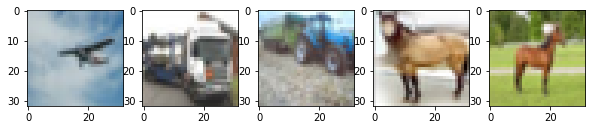

In [ ]:
import random
import matplotlib.pyplot as plt

def displayImage(x_test, index):

  return 


stop = len(x_test)
label = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

figure = plt.figure(figsize=(10,10))

for i in range(1,6):
    index = random.randrange(stop)
    figure.add_subplot(4, 5, i)
    plt.imshow(x_test[index])

    print('Image ' + str(i) + ' is a ' + label[y_true[index]] + ' our model predicted a '+ label[pred[index]])











